In [260]:
import numpy as np
import pandas as pd
import scipy.io
import random
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [261]:
data_set = scipy.io.loadmat('kmeans1.mat')
data_set.keys()
features = data_set['kmeans1']
df = pd.DataFrame(data=features)

Text(0.5, 1.0, 'Original Data')

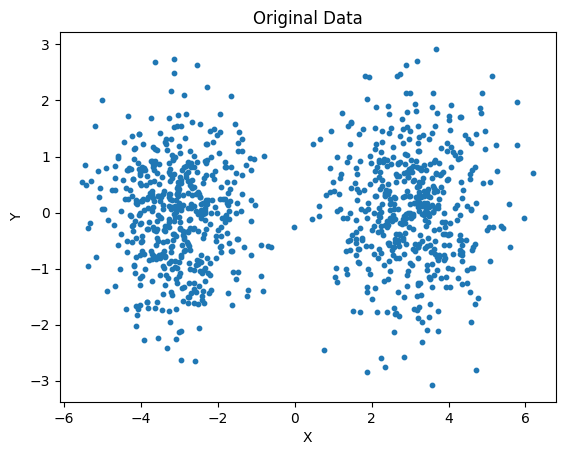

In [262]:
plt.scatter(df[0], df[1], s = 10, marker = "o")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Original Data")

In [263]:
def get_closest_centroid_and_distance(centroids, point):
    closest_centroid_index = -1
    closest_centroid_distance = 10000

    # finding the closest centroid
    for i, c in enumerate(centroids):
        dist = np.linalg.norm(c - point)
        if dist < closest_centroid_distance:
            closest_centroid_distance = dist
            closest_centroid_index = i

    return closest_centroid_distance, closest_centroid_index

In [264]:
def get_new_prototype(data, distances):
    distances = np.array(distances)
    probabilities = distances / np.sum(distances) #normalizing so distances sum to 1 and can be treated as prob
    return np.random.choice(data.shape[0], p=probabilities)

In [265]:
def get_starting_centroids(data, k):
    centroids = []
    centroids_index = random.sample(range(0, len(data)), k)
    for index in centroids_index:
        centroids.append(data.iloc[index].to_numpy())
    return centroids

In [266]:
def initialize_clusters(centroids):
    clusters = {}
    for i, _ in enumerate(centroids):
        clusters[i] = []
    return clusters

In [267]:
def get_prototypes(data, k):
    centroids = []
    centroids.append(data.iloc[random.sample(range(0, len(data)), 1)].to_numpy().flatten())

    while len(centroids) < k:
        distances = []
        for p in range(0,len(data)):
            data_point = data.iloc[p].to_numpy()
            closest_centroid_distance, _ = get_closest_centroid_and_distance(centroids, data_point)
            
            distances.append(closest_centroid_distance**2)
        
        new_centroid_index = get_new_prototype(data, distances)
        centroids.append(data.iloc[new_centroid_index].to_numpy())
    return centroids

In [268]:
def get_quantization_error(data, centroids):
    total_error = 0
    for p in range(0,len(data)):
        data_point = data.iloc[p].to_numpy()
        distance, _ = get_closest_centroid_and_distance(centroids, data_point)
        total_error += distance**2
    return total_error

In [269]:
def kmeans(data, k, plus=False):
    data_tracker = data.copy()
    data_tracker["Prev Cluster"] = np.nan
    can_reallocate = True
    centroid_history = []

    # Initializing the random starting centroids
    if plus:
        centroids = get_prototypes(data, k)
    else:
        centroids = get_starting_centroids(data, k)
        
    clusters = initialize_clusters(centroids)
    
    while can_reallocate:
        centroid_history.append(centroids.copy())
        is_cluster_different = []

        # Calculating distance from centroids for each data point
        for p in range(0,len(data)):
            data_point = data.iloc[p].to_numpy()
            _, closest_centroid_index = get_closest_centroid_and_distance(centroids, data_point)
                
            # Allocating points to centroid
            clusters[closest_centroid_index].append(data_point)
            is_cluster_different.append(data_tracker["Prev Cluster"][p] == closest_centroid_index)
            data_tracker.loc[p, "Prev Cluster"] = closest_centroid_index

        can_reallocate = False in is_cluster_different

        # Recalculating centroids
        if can_reallocate:
            for i, c in enumerate(clusters):
                centroids[i] = np.average(clusters[c], axis=0)
                clusters[i] = []
    
    quantization_error = get_quantization_error(data, centroids)
    
    return centroids, centroid_history, clusters, quantization_error


In [270]:
# With help from https://muthu.co/mathematics-behind-k-mean-clustering-algorithm/ 
def plot_clusters(clusters, centroids, k, save=False, plus = False):
    fig = plt.figure()
    for cluster in clusters.values():
        cluster = pd.DataFrame(cluster)
        fig = plt.scatter(cluster[0], cluster[1], s = 10, marker = "o")
        for centroid in centroids:
            fig = plt.plot(centroid[0], centroid[1], marker = "x", c = "black")
    fig = plt.xlabel("X")
    fig = plt.ylabel("Y")
    if plus:
        fig = plt.title("K-Means++: Data Separated into k=" + str(k) + " Clusters")
    else:
        fig = plt.title("Data Separated into k=" + str(k) + " Clusters")
    if save:
        if plus:
            fig = plt.savefig(f"plus_Clusters_{k}.png")
        else:    
            fig = plt.savefig(f"Clusters_{k}.png")
        fig = plt.close()

In [271]:
def plot_centroids(centroid_history, k, save=False, plus=False):
    fig = plt.figure()
    for i, step in enumerate(centroid_history):
        if i < len(centroid_history)-1:
            prev_step = centroid_history[i+1]
        for j, point in enumerate(step):
            if i == 0:
                fig = plt.plot(point[0], point[1], c="blue", marker="x", markersize=8)
            elif i == len(centroid_history)-1:
                fig = plt.plot(point[0], point[1], c="green", marker="x", markersize=8)
            else:
                fig = plt.plot(point[0], point[1], c="black", marker="o", markersize=2)

            if i < len(centroid_history)-1:
                prev_point = prev_step[j]
                fig = plt.arrow(point[0], point[1], prev_point[0]-point[0], prev_point[1]-point[1], length_includes_head=True, color="red",head_width=0.05)
    fig = plt.xlabel("X")
    fig = plt.ylabel("Y")
    if plus:
        fig = plt.title("K-Means++: Movement of Centroids for k=" + str(k) + " Clusters")
    else:
        fig = plt.title("Movement of Centroids for k=" + str(k) + " Clusters")
    if save:
        if plus:
            fig = plt.savefig(f"plus_Centroid_History_{k}.png")
        else:
            fig = plt.savefig(f"Centroid_History_{k}.png")
        fig = plt.close()

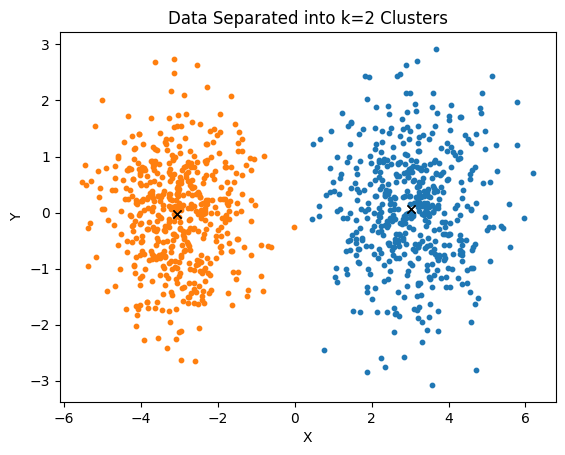

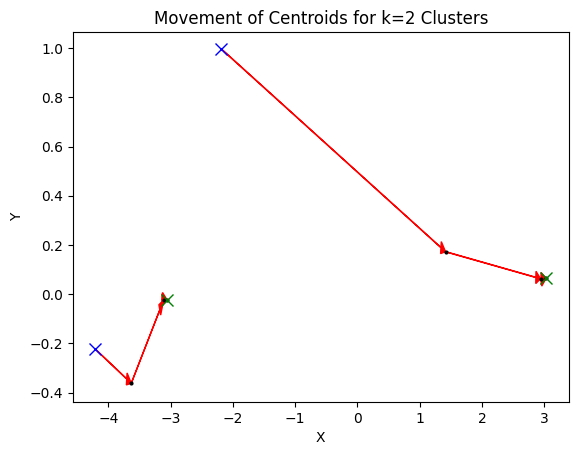

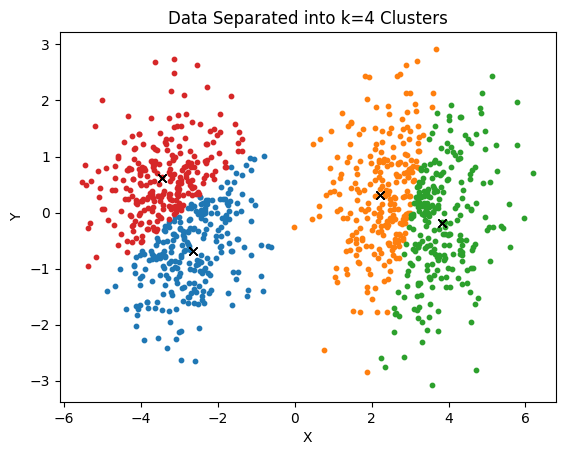

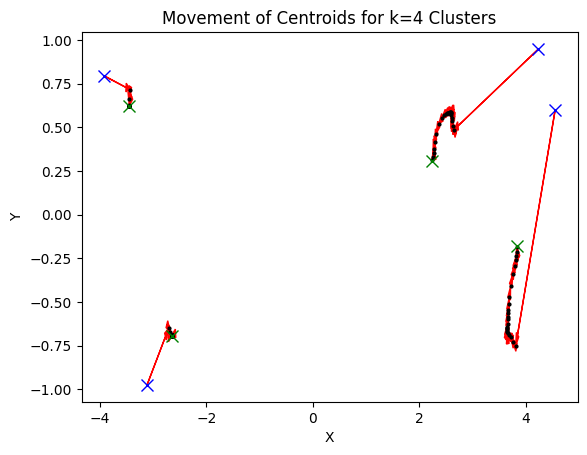

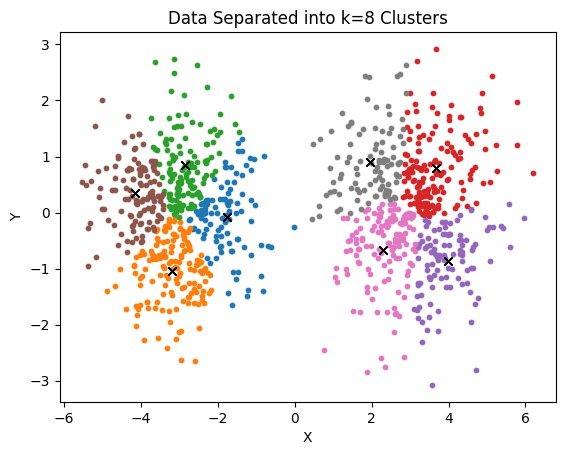

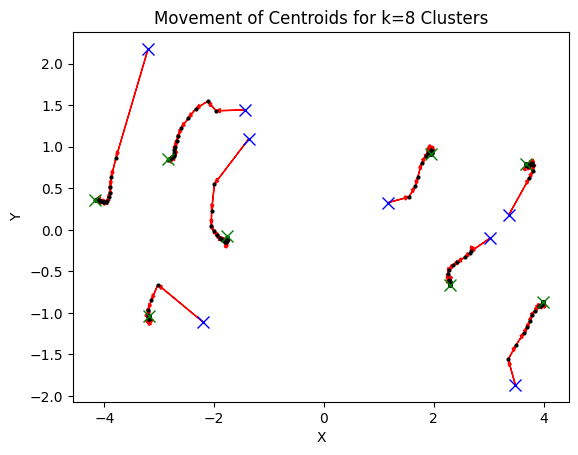

In [273]:
for k in [2,4,8]:
    centroids, history, clusters, _ = kmeans(df,k)
    plot_clusters(clusters, centroids, k, save=False)
    plot_centroids(history, k, save=False)

Text(0.5, 1.0, 'Checker Data')

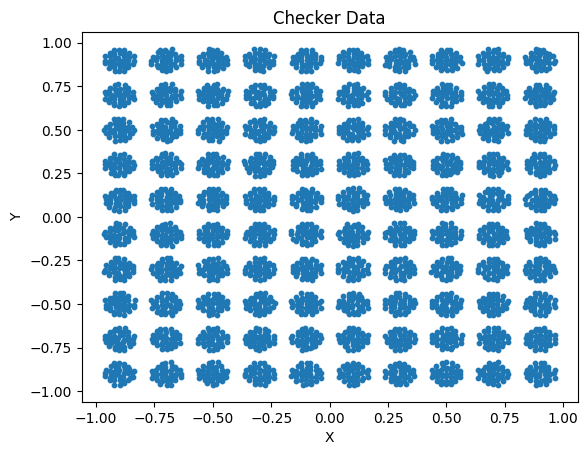

In [274]:
checker_data = scipy.io.loadmat('checkerboard.mat')
checker_data.keys()
features = checker_data['checkerboard']
checker_df = pd.DataFrame(data=features)
plt.scatter(checker_df[0], checker_df[1], s = 10, marker = "o")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Checker Data")

In [ ]:
k = 100
plus = False
save = True
errors = []
for r in range(0,20):
    centroids, history, clusters, error = kmeans(checker_df, k, plus=plus)
    errors.append(error)

In [ ]:
print("mean", np.mean(errors))
print("std", np.std(errors))

mean 16.205826283891774
std 1.2875963355815145


In [ ]:
k = 100
plus = True
save = True
plus_errors = []
for r in range(0,20):
    centroids, history, clusters, error = kmeans(checker_df, k, plus=plus)
    plus_errors.append(error)

In [ ]:
print("mean", np.mean(plus_errors))
print("std", np.std(plus_errors))

mean 13.321150238028107
std 0.8791342310359935


In [ ]:
stats.ttest_ind(a=plus_errors, b=errors, equal_var=True, alternative='less')

TtestResult(statistic=-8.06493559599073, pvalue=4.682247584416115e-10, df=38.0)